In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
import networks.continual_learning_beta as continual_learning_beta

from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
configOnline = configClasses.OnlineLearningConfig()
configOnline.L1_REG = 0
configOnline.EPOCHS = 20
configOnline.SAVE_PATH = './models/tecnique_comparison'
configOnline.IS_CONVOLUTIONAL = False
configOnline.MODEL_NAME = ''
print(configOnline)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/tecnique_comparison
USE_EWC: True
USE_TENSORBOARD: True



In [6]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [7]:
net = NoKafnet.MLP(len(dataset.class_to_idx))

In [8]:
results = []
experiments = [('no_cont_learning', None), 
               ('ewc', continual_learning.OnlineEWC),
               ('gem', continual_learning.GEM),
               ('embedding', continual_learning_beta.embedding)]

In [ ]:
for name, tec in experiments:
    print(name)
    
    n = deepcopy(net)
    config = deepcopy(configOnline)
    
    config.MODEL_NAME = name

    if 'name' == 'gem':
        config.EWC_IMPORTANCE = 0.5
        
    config.EWC_TYPE = tec
    
    trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
    
    results.append((name, r))
    
    del trainer
    del n

In [10]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics'])
    print()


RESULTS
no_cont_learning {'fwt': 0.8425952380952381, 'bwt': -0.04901190476190478, 'remembering': 0.9509880952380952, 'pbwt': 0, 'accuracy': 0.4300428571428572}

ewc {'fwt': 0.8633452380952381, 'bwt': -0.010559523809523816, 'remembering': 0.9894404761904761, 'pbwt': 0, 'accuracy': 0.41740714285714287}

gem {'fwt': 0.9328214285714287, 'bwt': 0.08947619047619045, 'remembering': 1, 'pbwt': 0.08947619047619045, 'accuracy': 0.3812142857142858}

embedding {'fwt': 0.8770595238095238, 'bwt': -0.01630952380952379, 'remembering': 0.9836904761904762, 'pbwt': 0, 'accuracy': 0.4273642857142857}



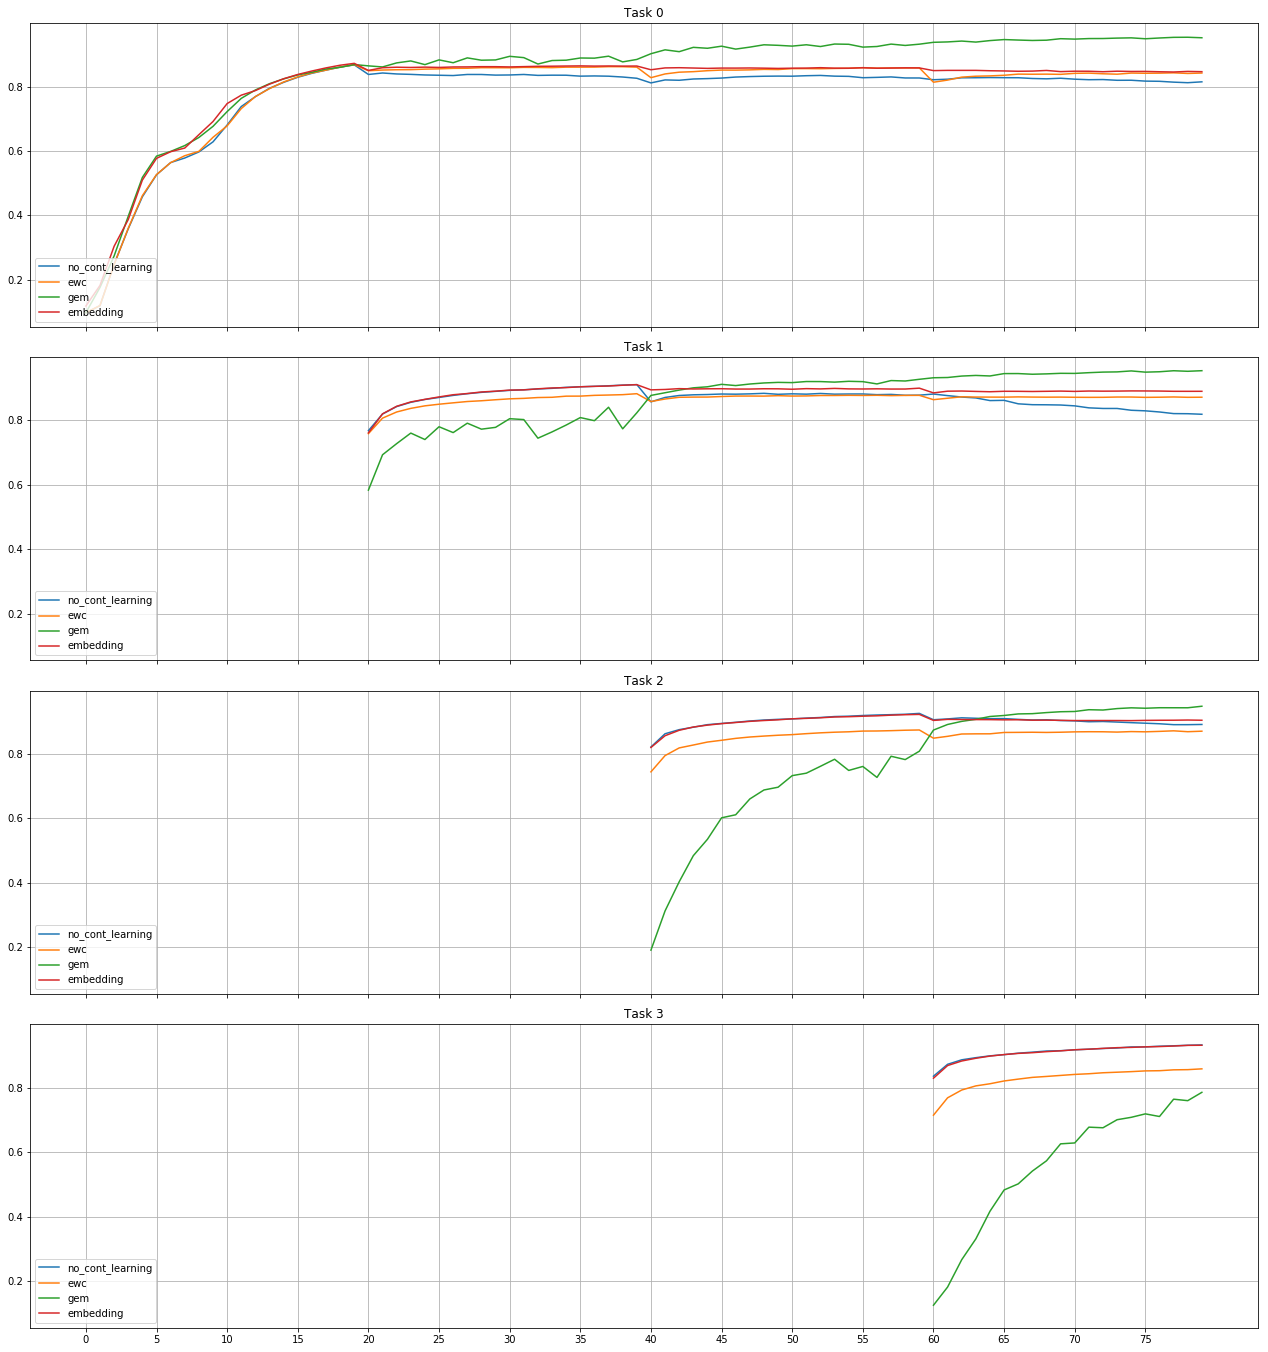

In [11]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=n_task, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]
        #no_ewt = metrics_no_ewt['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        #ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 

        ax[i].plot(x, com['accuracy'], label=name)
        #ax.plot(x, no_ewt['accuracy'], label='online ewt')

        ax[i].set_xticks(range(0, tot_epochs, 5),minor=False)

        ax[i].set_title("Task {}".format(task))
        ax[i].legend(loc="lower left")
        ax[i].grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)


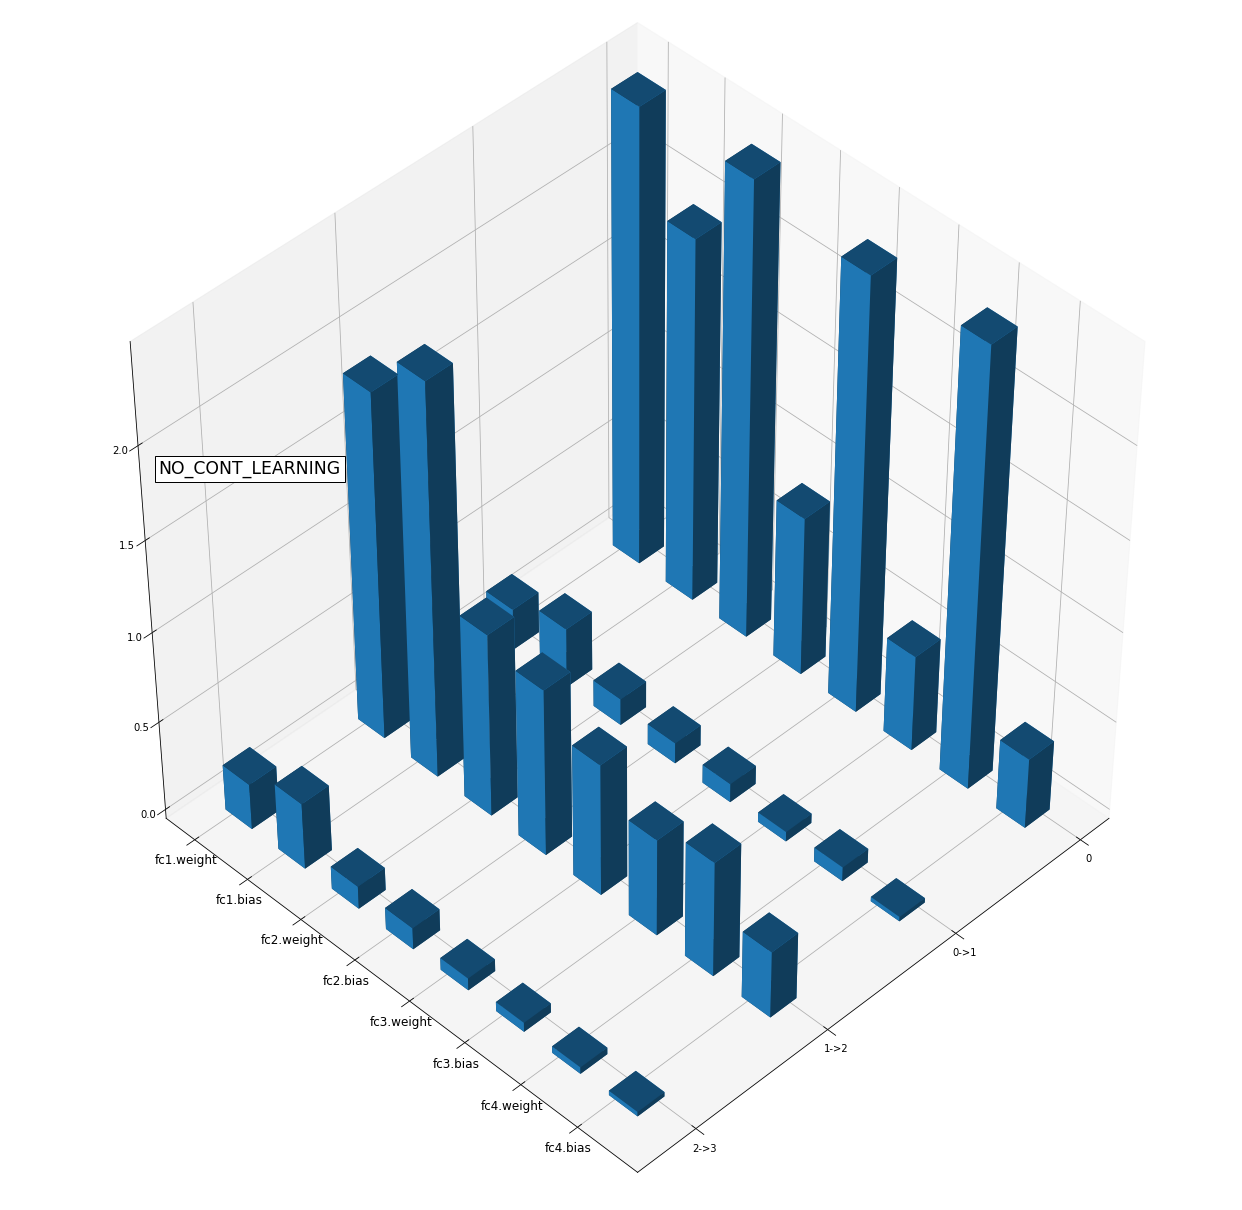

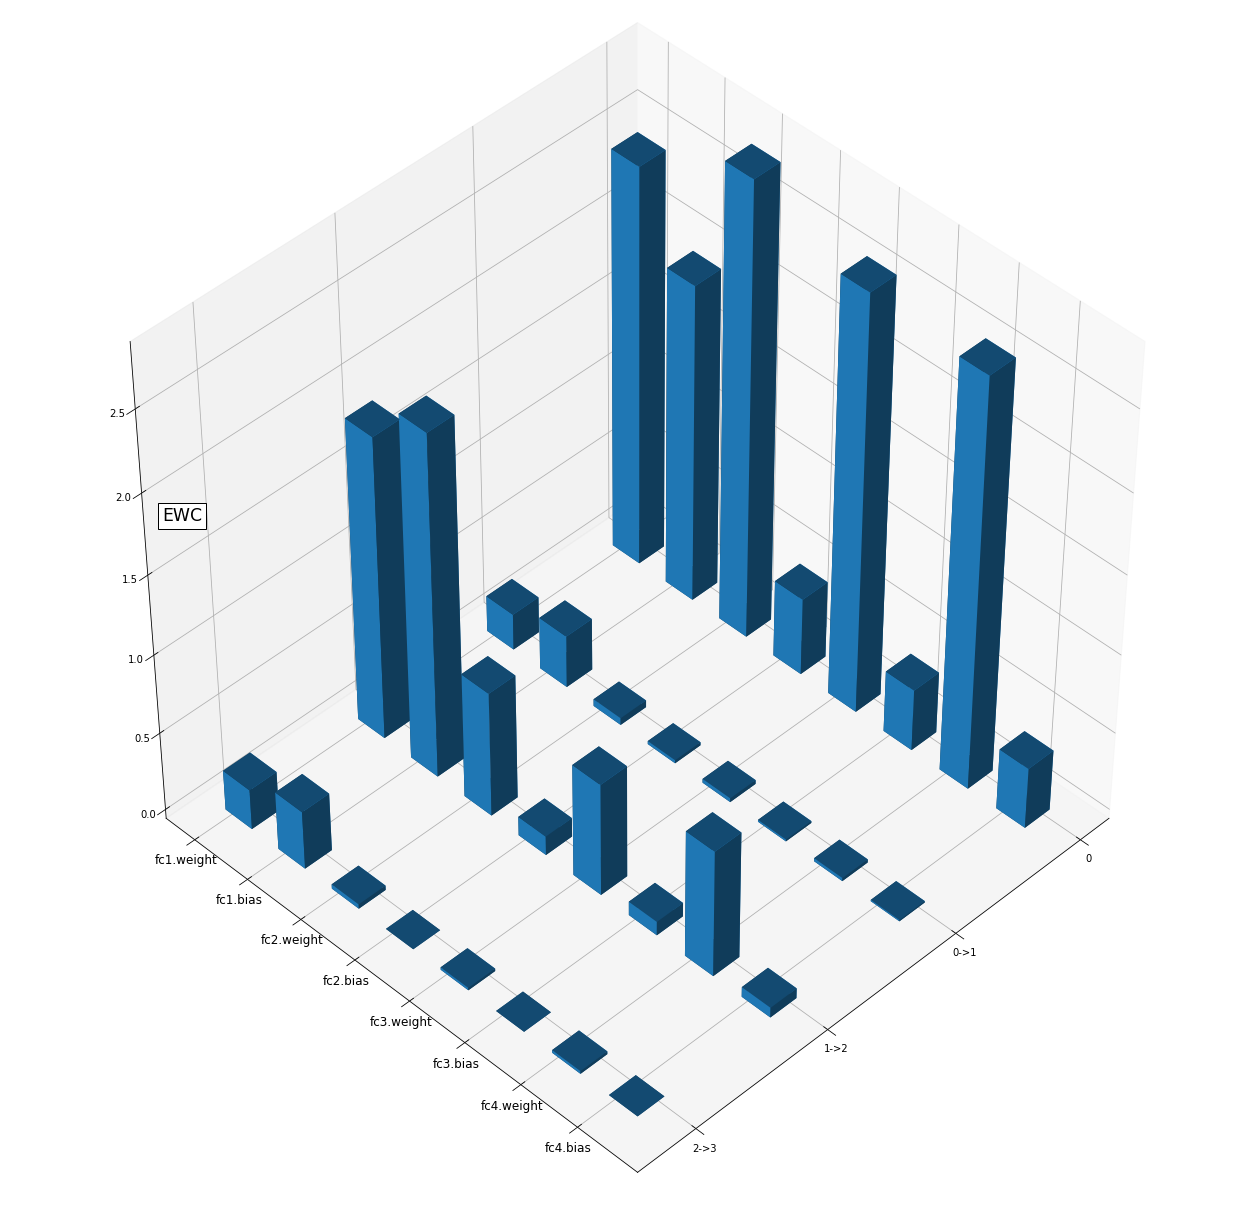

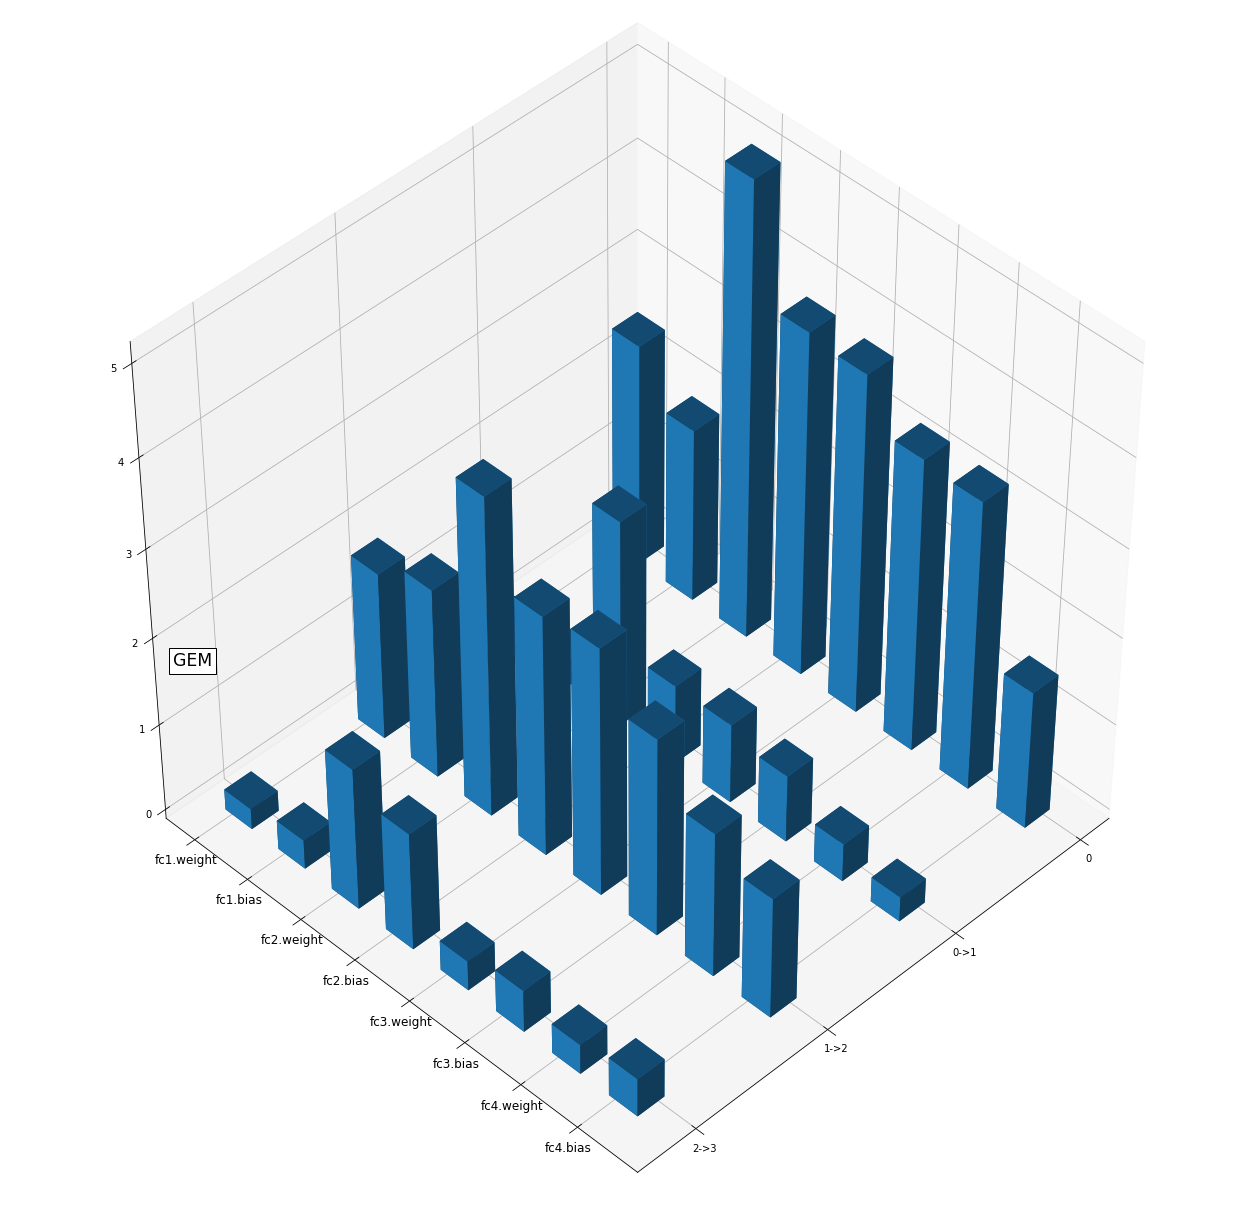

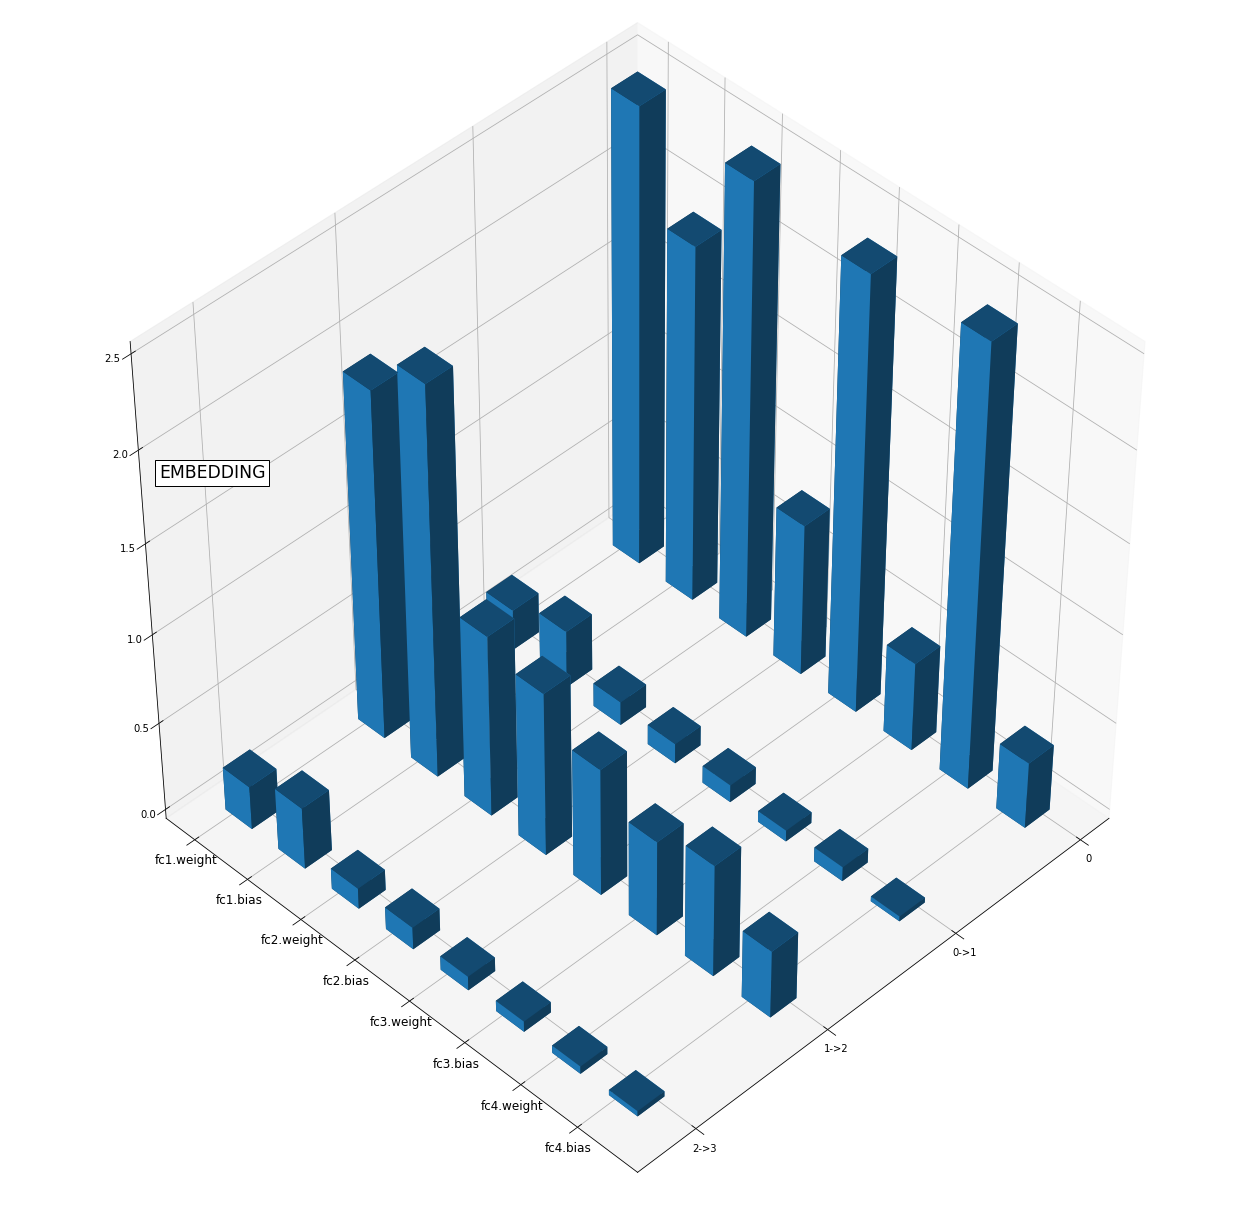

In [12]:
from mpl_toolkits.mplot3d import Axes3D

for name, tec in experiments:

    current_w = {n:p.cpu() for n, p in net.named_parameters() if p.requires_grad}

    x = np.arange(4)
    y = np.arange(len(current_w))
    
    xx, yy = np.meshgrid(x, y)
    z = np.zeros(shape=(len(x), len(y)))
    
    fig = plt.figure(figsize=(22, 22))
    ax = fig.add_subplot(111, projection='3d')
    
    x_labels = []
    
    for i in x:

        if i == 0:
            x_labels.append('0')
            
        else:
            x_labels.append('{}->{}'.format(i-1, i))
            
        n = deepcopy(net)
        config = deepcopy(configOnline)

        config.MODEL_NAME = name

        if 'name' == 'gem':
            config.EWC_IMPORTANCE = 0.5

        config.EWC_TYPE = tec

        trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

        r = trainer.load(i)
        
        diff = {n: torch.dist(p.cpu(), current_w[n]) for n, p in trainer.model.named_parameters() if p.requires_grad }
        current_w = {n: p.cpu() for n, p in trainer.model.named_parameters() if p.requires_grad }
        
        for j, (_, d) in enumerate(diff.items()):
            z[i, j] = d
    

    z_n = z.flatten()

    ax.view_init(45, 45)
    
    ax.bar3d(xx.flatten(),
          yy.flatten(),
          np.zeros(len(z_n)),
          0.2, 0.5, z_n )
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    ax.set_yticks(y)
    ax.set_yticklabels(list(diff.keys()), fontdict={'fontsize':12})
    
    ax.text(3.5, 0, 2, name.upper(), color='black',  fontsize='xx-large', 
        bbox=dict(facecolor='white', edgecolor='black'))
    
    plt.show()